## Path Tracking

In [6]:
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt

Define Kinematic Model

In [7]:
class KinematicModel:

  def __init__(self, x, y, psi, v, L, dt):
    self.x = x
    self.y = y
    self.psi = psi
    self.v = v
    self.L = L # distance bewteen car and closetest track point
    self.dt = dt  # discrete model

  def update_state(self, a, delta_f):
    self.x = self.x+self.v*math.cos(self.psi)*self.dt
    self.y = self.y+self.v*math.sin(self.psi)*self.dt
    self.psi = self.psi+self.v/self.L*math.tan(delta_f)*self.dt
    self.v = self.v+a*self.dt

  def get_state(self):
    return self.x, self.y, self.psi, self.v

PID Controller

In [8]:
class PID_posion:

    def __init__(self, kp, ki, kd, target, upper=1., lower=-1.):
        self.kp = kp
        self.ki = ki
        self.kd = kd
        self.err = 0  # error
        self.err_last = 0 # previous error
        self.err_all = 0 # sum of error
        self.target = target
        self.upper = upper # upper bound of output
        self.lower = lower # lower bound of output
        self.value = 0

    def cal_output(self, state):
        self.err = self.target - state
        self.value = self.kp * self.err + self.ki * \
            self.err_all + self.kd * (self.err - self.err_last)
        self.update()
        return self.value

    def update(self):
        self.err_last = self.err
        self.err_all = self.err_all + self.err
        if self.value > self.upper:
            self.value = self.upper
        elif self.value < self.lower:
            self.value = self.lower

    def reset(self):
        self.err = 0
        self.err_last = 0
        self.err_all = 0

    def set_target(self, target):
        self.target = target


Get the closest track point

In [9]:
def cal_target_index(robot_state,refer_path):
    dists = []
    for xy in refer_path:
        dis = np.linalg.norm(robot_state-xy)
        dists.append(dis)
    min_index = np.argmin(dists)
    return min_index

Path tracking

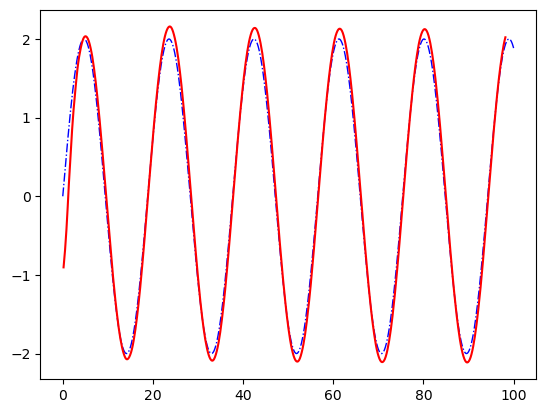

In [10]:
# set reference trajectory
refer_path = np.zeros((1000, 2))
refer_path[:,0] = np.linspace(0, 100, 1000) 
refer_path[:,1] = 2*np.sin(refer_path[:,0]/3.0)

# Initial state
ugv = KinematicModel(0,-1,0.5,2,2,0.1)
k=0.1
c=2
x_ = []
y_ = []

PID = PID_posion(kp = 2, ki = 0.01, kd = 30, target=0, upper=np.pi/6, lower=-np.pi/6)

for i in range(550):
    robot_state = np.zeros(2)
    robot_state[0] = ugv.x
    robot_state[1] = ugv.y
    ind = cal_target_index(robot_state,refer_path)

    alpha = math.atan2(refer_path[ind, 1]-robot_state[1], refer_path[ind, 0]-robot_state[0])
    l_d = np.linalg.norm(refer_path[ind]-robot_state)
    theta_e = alpha-ugv.psi
    e_y = -l_d*math.sin(theta_e)  
    delta_f = PID.cal_output(e_y)
    # print(e_y)
    # print(alpha)
    ugv.update_state(0,delta_f) # accelaration = 0

    x_.append(ugv.x)
    y_.append(ugv.y)


plt.figure(2)
plt.plot(refer_path[:, 0], refer_path[:, 1], '-.b', linewidth=1.0)
plt.plot(x_,y_,'r')
plt.show()